---
**License**

 NC_ccl_xcor_dndz_histograms

 Thu Feb 29 12:00:00 2024\
 Copyright  2024\
 Luigi Lucas de Carvalho Silva <luigi.lcsilva@gmail.com>

---
---

 NC_ccl_xcor_dndz_histograms\
 Copyright (C) 2024 Luigi Lucas de Carvalho Silva <luigi.lcsilva@gmail.com>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

## Startups and Packages

First of all, let us import some useful packages.

In [1]:
######## NUMCOSMO ########
from numcosmo_py import Ncm, Nc

######## CCL ########
import pyccl as pyccl

######## GENERAL ########
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
import time

######## COMPARISSON ########
from numcosmo_py.ccl.nc_ccl import CCLParams, create_nc_obj

ccl_params_class = CCLParams()
ccl_params_class.set_high_prec_params()

#create_nc_obj: Create a NumCosmo object from a CCL cosmology.
#ccl_params_class.set_high_prec_params(): Set CCL cosmology to high precision.

Now, let us get the libraries versions.

In [2]:
### GETTING NUMCOSMO VERSION
# dir(Ncm) # Show the library functions.

ncmpath = Ncm.__path__[0]
ncmpath = ncmpath.replace("/NumCosmoMath-1.0.typelib", "")
buildfile = open(ncmpath + "/build_cfg.h", "r").readlines()

for line in buildfile:
    if "NUMCOSMO_VERSION" in line:
        ncversion = line
        for ch in ["#define", "NUMCOSMO_VERSION", '"', "\n", "  "]:
            if ch in ncversion:
                ncversion = ncversion.replace(ch, "")
print("NumCosmo Version: " + ncversion)

### GETTING CCL VERSION
print("CCL Version: " + str(pyccl.__version__))

NumCosmo Version: 0.22.0
CCL Version: 3.1


Now, let us initialize the NumCosmo library.

In [3]:
Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

## Cosmological parameters

In [4]:
# Fixed parameters.
Neff_massless_neutrinos = 3.0  # Effective number of massless neutrinos present. For the massive case, the Neff is
# defined with the other parameters in the cosmology array.
T_CMB = 2.726  # The CMB temperature today.

######### COSMOLOGIES ##########
# Reference: https://arxiv.org/pdf/1812.05995.pdf, Table 3 and Table 4.
# Order of parameters: Omega_c, Omega_b, Omega_v, h, sigma8, n_s, w0, wa, Neff, m_nu
CCL_cosmologies = {}
### MASSLESS NEUTRINOS ####
CCL_cosmologies["CCL1"] = [
    0.25,
    0.05,
    0.7,
    0.7,
    0.8,
    0.96,
    -1.0,
    0.0,
    Neff_massless_neutrinos,
    0,
]  # flat ΛCDM
CCL_cosmologies["CCL2"] = [
    0.25,
    0.05,
    0.7,
    0.7,
    0.8,
    0.96,
    -0.9,
    0.0,
    Neff_massless_neutrinos,
    0,
]  # wCDM
CCL_cosmologies["CCL3"] = [
    0.25,
    0.05,
    0.7,
    0.7,
    0.8,
    0.96,
    -0.9,
    0.1,
    Neff_massless_neutrinos,
    0,
]  # wCDM
# CCL_cosmologies["CCL4"] = [0.25, 0.05, 0.65, 0.7, 0.8, 0.96, -0.9, 0.1, Neff_massless_neutrinos, 0] #open wCDM    # Bad results for k different from 0.
# CCL_cosmologies["CCL5"] = [0.25, 0.05, 0.75, 0.7, 0.8, 0.96, -0.9, 0.1, Neff_massless_neutrinos, 0] #closed wCDM  # Bad results for k different from 0.
# CCL_cosmologies["CCL6"] = [0.3, 0.0, 0.7, 0.7, 0.8, 0.96, -1.0, 0.0, Neff_massless_neutrinos, 0]    #flat ΛCDM    # Kernel dying for this cosmology
CCL_cosmologies["WMAP7"] = [
    0.2265,
    0.0455,
    0.728,
    0.704,
    0.810,
    0.967,
    -1.0,
    0.0,
    Neff_massless_neutrinos,
    0,
]  # flat ΛCDM
CCL_cosmologies["Planck2013"] = [
    0.269,
    0.0490,
    0.682,
    0.671,
    0.834,
    0.962,
    -1.0,
    0.0,
    Neff_massless_neutrinos,
    0,
]  # flat ΛCDM
### MASSIVE NEUTRINOS ####
# Obs.: The create_nc_obj from nc_ccl.py is not updated for the new version of CCL. So, we cannot include massive neutrinos right now.
# CCL_cosmologies["CCL7"] = [0.25, 0.05, 0.7, 0.7, 0.8, 0.96, -1.0, 0.0, 3.013, [0.04,0,0]]  #flat ΛCDM, mν

cosmo_names = []
for key, value in CCL_cosmologies.items():
    cosmo_names.append(key)

# Defining the tracers

In [5]:
###################### TIME START ##########################
start = time.time()

######## REDSHIFT DISTRIBUTION OF OBJECTS FROM HISTOGRAM ########
### Getting the redshift distribution for the objects from the CCL bin1_histo and bin2_histo files.
# Source: https://github.com/LSSTDESC/CCL/tree/master/benchmarks/data -- Files bin1_histo.txt and bin2_histo.txt
# Used in the CCL article: https://arxiv.org/pdf/1812.05995.pdf

# Loading the data. The txt files have 2 columns. The first column contains the redshift values,
# and the second column contains the dndz values.
bin1_histo = np.loadtxt(
    "./data/bin1_histo.txt", delimiter=" "
)  # Loading the first histogram.
len_bin1_histo = bin1_histo.shape[0]  # Getting the number of lines.

bin2_histo = np.loadtxt(
    "./data/bin2_histo.txt", delimiter=" "
)  # Loading the second histogram.
len_bin2_histo = bin2_histo.shape[0]  # Getting the number of lines.

# Saving the redshift in two lists.
z_bin1_histo = []
z_bin2_histo = []

for i in range(len_bin1_histo):
    z_bin1_histo.append(bin1_histo[i][0])

for i in range(len_bin2_histo):
    z_bin2_histo.append(bin2_histo[i][0])

z_bin1_histo_np = np.array(z_bin1_histo)
z_bin2_histo_np = np.array(z_bin2_histo)

# Checking if the histograms have the same number of lines, and if the redshifts values are equal.
if len_bin1_histo != len_bin2_histo:
    print("Different histograms size!")
else:
    print("Equal histograms size! \n")
    z_histo_diff = [z_bin1_histo[i] - z_bin2_histo[i] for i in range(len_bin1_histo)]
    count_z_histo_diff_nonzero = np.count_nonzero(z_histo_diff)
    if count_z_histo_diff_nonzero == 0:
        print("Redshifts are also equal!")

# Saving the dndz values in two lists.
dndz_bin1_histo = []
dndz_bin2_histo = []
for i in range(len_bin1_histo):
    dndz_bin1_histo.append(bin1_histo[i][1])

for i in range(len_bin2_histo):
    dndz_bin2_histo.append(bin2_histo[i][1])

dndz_bin1_histo_np = np.array(dndz_bin1_histo)
dndz_bin2_histo_np = np.array(dndz_bin2_histo)

###################### TIME END ##########################
end = time.time()
print(str(end - start) + "s")

Equal histograms size! 

Redshifts are also equal!
0.00315093994140625s


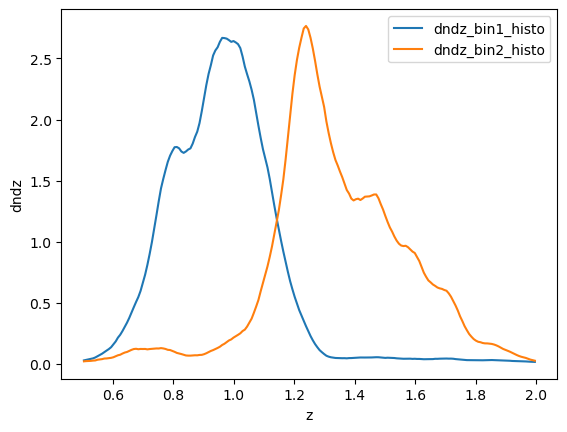

In [6]:
######## PLOT OF THE REDSHIFT DISTRIBUTIONS OF OBJECTS ########
plt.plot(z_bin1_histo, dndz_bin1_histo, label="dndz_bin1_histo")
plt.plot(z_bin2_histo, dndz_bin2_histo, label="dndz_bin2_histo")
plt.legend()
plt.xlabel("z")
plt.ylabel("dndz")
plt.show()

# Defining the functions for the comparisons

In [7]:
# Obs.: Problem with the "mass_function" in the nc_ccl.py file. I commented it there.
def compute_galaxy_galaxy_angular_cls(
    ells,
    Omega_c,
    Omega_b,
    Omega_v,
    h,
    sigma8,
    n_s,
    w0,
    wa,
    Neff,
    m_nu,
    z1,
    dndz1,
    z2=None,
    dndz2=None,
):
    """
    Compare the angular power spectrum of two galaxy type probes.

    Numcosmo apparently can't skip l's. It have just lmin and lmax as parameters in the angular power spectrum computation, in a continuous
    way.
    """
    ###################### TIME START ##########################
    start = time.time()

    ##### GENERAL #####
    # Set Omega_K in a consistent way
    Omega_k = 1.0 - Omega_c - Omega_b - Omega_v

    ##### COSMOLOGIES #####
    # Defining the CCL cosmology.
    ccl_cosmo = pyccl.Cosmology(
        Omega_c=Omega_c,
        Omega_b=Omega_b,
        Neff=Neff,
        m_nu=m_nu,
        h=h,
        n_s=n_s,
        Omega_k=Omega_k,
        Omega_g=None,
        w0=w0,
        wa=wa,
        sigma8=sigma8,
        transfer_function="eisenstein_hu",
        T_CMB=T_CMB,
        matter_power_spectrum="linear",
    )

    # Defining the NumCosmo cosmology.
    nc_cosmo = create_nc_obj(ccl_cosmo)
    # More info: https://github.com/NumCosmo/NumCosmo/blob/master/numcosmo_py/ccl/nc_ccl.py

    # Initialize tracers in CCL.
    trcs_ccl = dict()

    #### COMPUTING THE Cls #####
    if (z2 is None) and (dndz2 is None):
        print("Computing the auto angular power spectrum of one tracer.")
        ### Computing the angular power spectrum in CCL.
        unity_bias_1 = np.array([1 for i in np.arange(0, len(z1))])
        trcs_ccl["g1"] = pyccl.NumberCountsTracer(
            cosmo=ccl_cosmo,
            dndz=(z1, dndz1),
            bias=(z1, unity_bias_1),
            mag_bias=None,
            has_rsd=False,
        )
        ccl_cl = pyccl.angular_cl(ccl_cosmo, trcs_ccl["g1"], trcs_ccl["g1"], ells)
        ccl_cl = np.array(ccl_cl)

        ### Computing the angular power spectrum in NumCosmo.
        # Defining Ncm vectors.
        v_z1 = Ncm.Vector.new_array(z1)
        v_pz1 = Ncm.Vector.new_array(dndz1)

        # Defining the splines.
        s_pz1 = Ncm.SplineCubicNotaknot.new_full(v_z1, v_pz1, True)

        # Defining the kernels.
        nc_g1 = None
        nc_g1 = Nc.XcorLimberKernelGal.new(
            z1[0], z1[-1], 1, 0.0, s_pz1, nc_cosmo.dist, False
        )

        # Pushing the objects to mset in NumCosmo.
        mset = Ncm.MSet.empty_new()
        mset.set(nc_cosmo.cosmo)
        mset.push(nc_g1)

        # Setting the function to compute the angular power spectrum in NumCosmo.
        xcor = Nc.Xcor.new(nc_cosmo.dist, nc_cosmo.ps_ml, Nc.XcorLimberMethod.GSL)

        # Getting the size of the ells array.
        len_l = ells.size

        # Defining a Ncm vector for saving the cls.
        nc_cl = Ncm.Vector.new(len_l)

        # Preparing things.
        xcor.prepare(nc_cosmo.cosmo)
        nc_g1.prepare(nc_cosmo.cosmo)

        # Computing the angular power spectrum.
        xcor.limber(nc_g1, nc_g1, nc_cosmo.cosmo, ells[0], ells[-1], nc_cl)

        # Getting the results and converting them to Numpy arrays.
        nc_cl_values = [Ncm.Vector.get(nc_cl, i) for i in np.arange(0, len_l)]
        nc_cl = np.array(nc_cl_values)
    else:
        print("Computing the cross angular power spectrum of two tracers.")
        ### Computing the angular power spectrum in CCL.
        unity_bias_1 = np.array([1 for i in np.arange(0, len(z1))])
        unity_bias_2 = np.array([1 for i in np.arange(0, len(z2))])
        trcs_ccl["g1"] = pyccl.NumberCountsTracer(
            cosmo=ccl_cosmo,
            dndz=(z1, dndz1),
            bias=(z1, unity_bias_1),
            mag_bias=None,
            has_rsd=False,
        )
        trcs_ccl["g2"] = pyccl.NumberCountsTracer(
            cosmo=ccl_cosmo,
            dndz=(z2, dndz2),
            bias=(z2, unity_bias_2),
            mag_bias=None,
            has_rsd=False,
        )
        ccl_cl = pyccl.angular_cl(ccl_cosmo, trcs_ccl["g1"], trcs_ccl["g2"], ells)
        ccl_cl = np.array(ccl_cl)

        ### Computing the angular power spectrum in NumCosmo.
        # Defining Ncm vectors.
        v_z1 = Ncm.Vector.new_array(z1)
        v_z2 = Ncm.Vector.new_array(z2)
        v_pz1 = Ncm.Vector.new_array(dndz1)
        v_pz2 = Ncm.Vector.new_array(dndz2)

        # Defining the splines.
        s_pz1 = Ncm.SplineCubicNotaknot.new_full(v_z1, v_pz1, True)
        s_pz2 = Ncm.SplineCubicNotaknot.new_full(v_z2, v_pz2, True)

        # Defining the kernels.
        nc_g1 = None
        nc_g2 = None
        nc_g1 = Nc.XcorLimberKernelGal.new(
            z1[0], z1[-1], 1, 0.0, s_pz1, nc_cosmo.dist, False
        )
        nc_g2 = Nc.XcorLimberKernelGal.new(
            z2[0], z2[-1], 1, 0.0, s_pz2, nc_cosmo.dist, False
        )

        # Pushing the objects to mset in NumCosmo.
        mset = Ncm.MSet.empty_new()
        mset.set(nc_cosmo.cosmo)
        mset.push(nc_g1)
        mset.push(nc_g2)

        # Setting the function to compute the angular power spectrum in NumCosmo.
        xcor = Nc.Xcor.new(nc_cosmo.dist, nc_cosmo.ps_ml, Nc.XcorLimberMethod.GSL)

        # Getting the size of the ells array.
        len_l = ells.size

        # Defining a Ncm vector for saving the cls.
        nc_cl = Ncm.Vector.new(len_l)

        # Preparing things.
        xcor.prepare(nc_cosmo.cosmo)
        nc_g1.prepare(nc_cosmo.cosmo)
        nc_g2.prepare(nc_cosmo.cosmo)

        # Computing the angular power spectrum.
        xcor.limber(nc_g1, nc_g2, nc_cosmo.cosmo, ells[0], ells[-1], nc_cl)

        # Getting the results and converting them to Numpy arrays.
        nc_cl_values = [Ncm.Vector.get(nc_cl, i) for i in np.arange(0, len_l)]
        nc_cl = np.array(nc_cl_values)

    ###################### TIME END ##########################
    end = time.time()
    print("Elapsed time: " + str(end - start) + "s")
    return ccl_cl, nc_cl


def compute_abs_relative_diff(array_ref, array_comp):
    relative_diff = np.abs((array_ref - array_comp) / array_ref)
    return relative_diff


def compute_accuracy_metric_cross(auto1_ref, auto2_ref, cross_ref, cross_comp, ells):
    ### ACCURACY METRIC ###
    # Source: page 28, https://arxiv.org/pdf/1812.05995.pdf
    Cab_comp = cross_comp

    ### The reference to compute sig_l
    Caa_ref = auto1_ref
    Cbb_ref = auto2_ref
    Cab_ref = cross_ref

    intern_fact = (Caa_ref * Cbb_ref + Cab_ref**2) / (2 * ells + 1)
    sig_l = np.sqrt(intern_fact)

    A_acc_cross = np.abs((Cab_comp - Cab_ref) / sig_l)

    return A_acc_cross


def compute_accuracy_metric_auto(auto_ref, auto_comp, ells):
    ## AUTO 1
    # For cross PS of fields a and b, we must have Caa, Cbb and Cab of the independent realization.
    # For auto PS of field a, Caa, Cbb and Cab can be set to the same value.

    Caa_comp = auto_comp

    ### The reference to compute sig_l
    Caa_ref = auto_ref

    intern_fact = (2 * Caa_ref**2) / (2 * ells + 1)
    sig_l = np.sqrt(intern_fact)

    A_acc_auto = np.abs((Caa_comp - Caa_ref) / sig_l)

    return A_acc_auto


def compute_multiple_cosmologies_angular_cls(
    chosen_cosmologies, ells, z1, dndz1, z2=None, dndz2=None
):
    CCL_cls = {}
    NC_cls = {}
    A_acc = {}
    ###### Running the loop
    for cosmology in chosen_cosmologies:
        Omega_c = CCL_cosmologies[cosmology][0]
        Omega_b = CCL_cosmologies[cosmology][1]
        Omega_v = CCL_cosmologies[cosmology][2]
        h = CCL_cosmologies[cosmology][3]
        sigma8 = CCL_cosmologies[cosmology][4]
        n_s = CCL_cosmologies[cosmology][5]
        w0 = CCL_cosmologies[cosmology][6]
        wa = CCL_cosmologies[cosmology][7]
        Neff = CCL_cosmologies[cosmology][8]
        m_nu = CCL_cosmologies[cosmology][9]

        if z2 is None and dndz2 is None:
            calc_type = "AUTO"
        else:
            calc_type = "CROSS"

        print("Cosmology: " + str(cosmology))
        print("Type: " + str(calc_type))

        CCL_cls[cosmology], NC_cls[cosmology] = compute_galaxy_galaxy_angular_cls(
            ells,
            Omega_c,
            Omega_b,
            Omega_v,
            h,
            sigma8,
            n_s,
            w0,
            wa,
            Neff,
            m_nu,
            z1,
            dndz1,
            z2,
            dndz2,
        )

        A_acc[cosmology] = compute_accuracy_metric_auto(
            NC_cls[cosmology], CCL_cls[cosmology], ells
        )
    return CCL_cls, NC_cls, A_acc

# Auto Angular Power Spectrum: Histogram 1, as extracted from bin1_histo.txt

## Computing the Cls

First, let us define some inputs for the Cls computation.

In [8]:
##### INPUT #####

#### Defining the array of ells
lmax = 3000
ells = np.arange(lmax + 1)
ells = ells[1:]
print("ells= " + str(ells))

### Defining the histograms to use.
### Put None if not using.
z1 = z_bin1_histo_np
dndz1 = dndz_bin1_histo_np
z2 = None
dndz2 = None
chosen_type = "_AUTO_HISTO_1"

### Defining the cosmologies to compute
chosen_cosmologies = ["CCL1", "CCL2", "CCL3"]

ells= [   1    2    3 ... 2998 2999 3000]


Now, let us compute the Cls.

In [20]:
CCL_cls_histo1, NC_cls_histo1, A_acc_histo1 = compute_multiple_cosmologies_angular_cls(
    chosen_cosmologies, ells, z1, dndz1, z2, dndz2
)

Cosmology: CCL1
Type: AUTO
Computing the auto angular power spectrum of one tracer.
Elapsed time: 8.546706438064575s
Cosmology: CCL2
Type: AUTO
Computing the auto angular power spectrum of one tracer.


WARNING 18: ccl_cls.c: integ_cls_limber_qag_quad(): Default GSL integration failure, attempting backup method.: GSL ERROR: roundoff error
WARNING 18: ccl_cls.c: integ_cls_limber_qag_quad(): Default GSL integration failure, attempting backup method.: GSL ERROR: roundoff error
WARNING 18: ccl_cls.c: integ_cls_limber_qag_quad(): Default GSL integration failure, attempting backup method.: GSL ERROR: roundoff error
WARNING 18: ccl_cls.c: integ_cls_limber_qag_quad(): Default GSL integration failure, attempting backup method.: GSL ERROR: roundoff error
WARNING 18: ccl_cls.c: integ_cls_limber_qag_quad(): Default GSL integration failure, attempting backup method.: GSL ERROR: roundoff error
WARNING 18: ccl_cls.c: integ_cls_limber_qag_quad(): Default GSL integration failure, attempting backup method.: GSL ERROR: roundoff error
WARNING 18: ccl_cls.c: integ_cls_limber_qag_quad(): Default GSL integration failure, attempting backup method.: GSL ERROR: roundoff error


Elapsed time: 8.62447476387024s
Cosmology: CCL3
Type: AUTO
Computing the auto angular power spectrum of one tracer.
Elapsed time: 9.443256139755249s


Finally, let us make the plots.

First, the Cls plots.

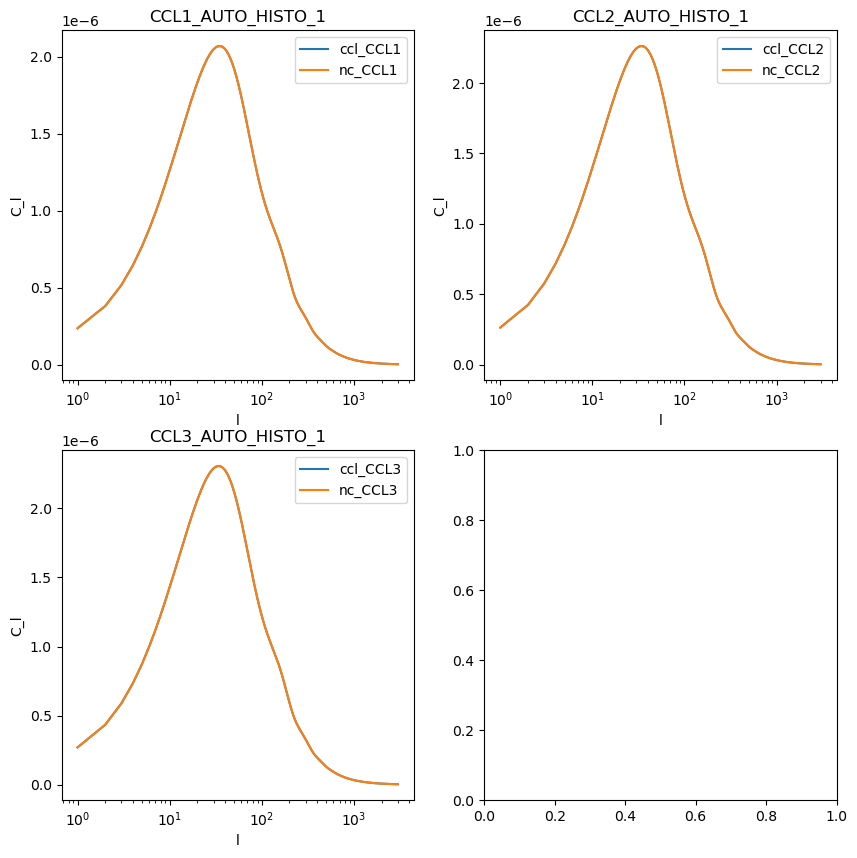

In [10]:
### Making the plots.
CCL_cls = CCL_cls_histo1
NC_cls = NC_cls_histo1
###### Defining the figure
max_len = len(CCL_cls)
col_num = 2
size_ref = 5
line_num = math.ceil(max_len / col_num)
fig, axs = plt.subplots(
    line_num, col_num, figsize=(col_num * size_ref, line_num * size_ref)
)

loop_index = 0
### Running the loop ###
for i in np.arange(0, line_num, 1):
    for j in np.arange(0, col_num, 1):
        if loop_index < len(chosen_cosmologies):
            ind = chosen_cosmologies[loop_index]
            y1 = CCL_cls[ind]
            y2 = NC_cls[ind]

            axs[i, j].plot(ells, y1, label="ccl_" + ind)
            axs[i, j].plot(ells, y2, label="nc_" + ind)
            axs[i, j].set_title(ind + chosen_type)
            axs[i, j].legend()
            axs[i, j].set(xlabel="l", ylabel="C_l")
            axs[i, j].set(xscale="log")
        loop_index += 1

Second, the accuracy plots.

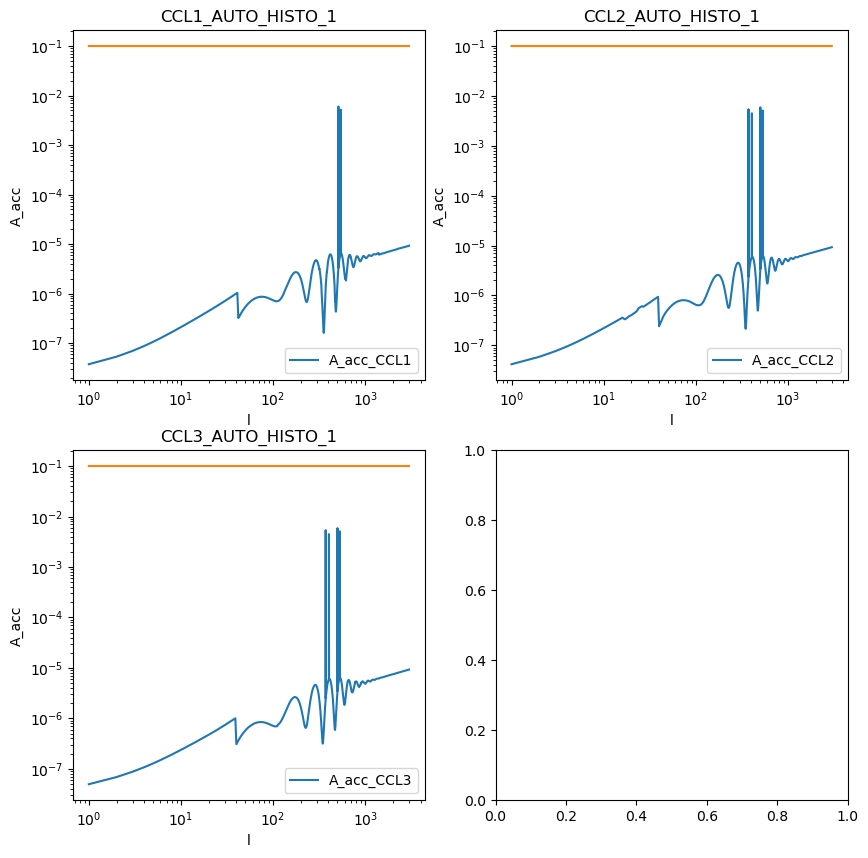

In [11]:
### Making the plots.
A_acc = A_acc_histo1
###### Defining the figure
max_len = len(A_acc)
col_num = 2
size_ref = 5
line_num = math.ceil(max_len / col_num)
fig, axs = plt.subplots(
    line_num, col_num, figsize=(col_num * size_ref, line_num * size_ref)
)

expected_acc = np.empty(len(ells))
expected_acc.fill(0.1)

loop_index = 0
### Running the loop ###
for i in np.arange(0, line_num, 1):
    for j in np.arange(0, col_num, 1):
        if loop_index < len(chosen_cosmologies):
            ind = chosen_cosmologies[loop_index]
            y1 = A_acc[ind]

            axs[i, j].plot(ells, y1, label="A_acc_" + ind)
            axs[i, j].plot(ells, expected_acc)
            axs[i, j].set_title(ind + chosen_type)
            axs[i, j].legend()
            axs[i, j].set(xlabel="l", ylabel="A_acc")
            axs[i, j].set(xscale="log")
            axs[i, j].set(yscale="log")
        loop_index += 1

## Analyzing the problematic points

First, let us define some inputs for the analysis.

In [14]:
##### INPUT #####

chosen_cosmo = "CCL2"
chosen_acc_dic = A_acc_histo1
chosen_ccl_dic = CCL_cls_histo1
chosen_nc_dic = NC_cls_histo1

Now, let us catch the problematic ells.

Problematic ells: [373 406 502 533]
Corresponding A_acc: [0.00540559 0.00448452 0.00589716 0.00508608]
lines_lim= [373 406 502 533]


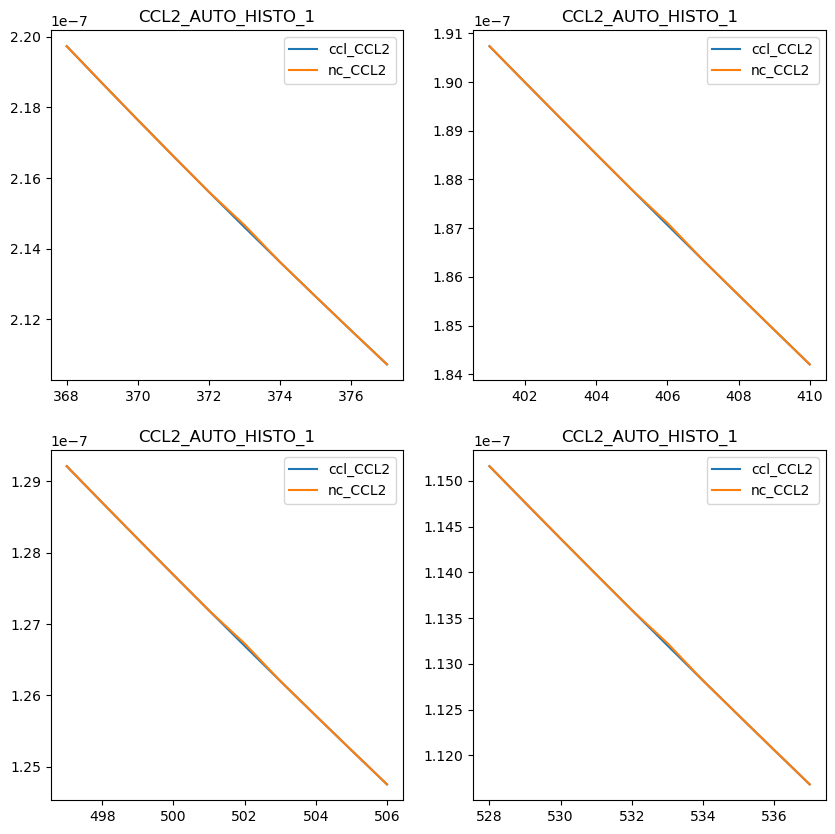

In [19]:
problematic_ells = np.where(chosen_acc_dic[chosen_cosmo] > 0.0001)[0]
problematic_ells_A_acc_values = chosen_acc_dic[chosen_cosmo][problematic_ells]

print("Problematic ells: " + str(problematic_ells))
print("Corresponding A_acc: " + str(problematic_ells_A_acc_values))

### Plot configuration ###
col_lim = 2
size_config = 5
### Defining the interval around the problematic ell to be plotted ###
plot_interval = 5

######## CODE ########
### Defining the figure and line limits ###
if len(problematic_ells) % col_lim == 0:
    lines_lim = len(problematic_ells) // col_lim
else:
    lines_lim = len(problematic_ells) // col_lim + 1
print("lines_lim= " + str(problematic_ells))

fig, axs = plt.subplots(
    lines_lim, col_lim, figsize=(col_lim * size_config, lines_lim * size_config)
)

### Running the loop ###
p_ell_index = 0
stop = len(problematic_ells)
for i in np.arange(0, lines_lim, 1):
    for j in np.arange(0, col_lim, 1):
        if p_ell_index < stop:
            p_ell = problematic_ells[p_ell_index]

            x = np.arange(p_ell - plot_interval, p_ell + plot_interval, 1)
            y1 = chosen_ccl_dic[chosen_cosmo][x]
            y2 = chosen_nc_dic[chosen_cosmo][x]

            axs[i, j].plot(x, y1, label="ccl_" + chosen_cosmo)
            axs[i, j].plot(x, y2, label="nc_" + chosen_cosmo)
            axs[i, j].set_title(chosen_cosmo + chosen_type)
            axs[i, j].legend()
        p_ell_index += 1